<a href="https://colab.research.google.com/github/rohansawai/Suicide_Depressive_Detect/blob/main/BERT_Models/BERT_Training_andTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers


     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 36.3 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 895 kB 28.5 MB/s 
     |████████████████████████████████| 6.5 MB 27.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
#importing relevant libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

import torch

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import files
import pandas as pd
import io
import os

uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['suicide_preBERT1.csv']))


Saving suicide_preBERT1.csv to suicide_preBERT1.csv


In [6]:
df = df.drop(['length'], axis = 1)
df.head(5)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,1,0
0,We understand people reply immediately OP invi...,0
1,Welcome /r/depression's check-in post - place ...,0
2,Dammit I eat often,0
3,I bachelors science psychology it’s complete f...,0
4,"Just want preface saying fucked up, I know it....",0


In [7]:
og_batch_1 = df[['1', '0']]
batch_1 = og_batch_1.rename(columns={'1': 0, '0': 1})
batch_1.head()



,0,1
0,We understand people reply immediately OP invi...,0
1,Welcome /r/depression's check-in post - place ...,0
2,Dammit I eat often,0
3,I bachelors science psychology it’s complete f...,0
4,"Just want preface saying fucked up, I know it....",0


In [8]:
batch_1[1].value_counts()


0    992
1    980
Name: 1, dtype: int64

In [10]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=128)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])


In [13]:
np.array(padded).shape


(1972, 128)

In [14]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1972, 128)

In [15]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)


In [16]:
features = last_hidden_states[0][:,0,:].numpy()
print(features)


[[-0.03651115 -0.2654599   0.55972016 ... -0.12037563  0.32727933
   0.5229549 ]
 [ 0.11105429 -0.32040343  0.22627799 ... -0.20752996  0.30909368
   0.5695855 ]
 [ 0.09152143  0.42219874 -0.23317084 ... -0.02085229  0.14157268
   0.20402782]
 ...
 [-0.16295767  0.31265548 -0.26017138 ... -0.23124778  0.3089668
   0.05982853]
 [-0.06365631  0.19286785 -0.2080162  ... -0.6924433  -0.62857306
   0.4173686 ]
 [-0.04062695  0.04952637  0.44396362 ... -0.47051266  0.2542503
   0.26426005]]


In [17]:
labels = batch_1[1]
labels.head()


0    0
1    0
2    0
3    0
4    0
Name: 1, dtype: int64

In [18]:
np.savetxt("real_data_for_model_features.csv", features, delimiter=',')
features.shape


(1972, 768)

In [19]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42, stratify=labels)


In [20]:
train_features = np.asarray(train_features)
train_labels = np.asarray(train_labels)
test_features = np.asarray(test_features)
test_labels = np.asarray(test_labels)


In [21]:
features.shape


(1972, 768)

In [22]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, Input

model3 = Sequential()

model3.add(Input(shape=(768,), name="input_word_ids"))

model3.add(Dense(1, activation='sigmoid'))

model3.add(Dense(10, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#checkpoint = ModelCheckpoint('/content/depression_suicide_neither_nn.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

history = model3.fit(train_features, train_labels, batch_size=32, epochs=100, verbose=1, validation_data=(test_features, test_labels))


Epoch 1/100
47/47 [==============================] - 4s 9ms/step - loss: 0.6918 - accuracy: 0.5051 - val_loss: 0.6874 - val_accuracy: 0.5822
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5720 - val_loss: 0.6803 - val_accuracy: 0.5903
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy: 0.5869 - val_loss: 0.6726 - val_accuracy: 0.6126
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6732 - accuracy: 0.5991 - val_loss: 0.6661 - val_accuracy: 0.6247
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6657 - accuracy: 0.6247 - val_loss: 0.6591 - val_accuracy: 0.6389
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6574 - accuracy: 0.6329 - val_loss: 0.6519 - val_accuracy: 0.6511
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6497 - accuracy: 0.6430 - val_loss: 0.6456 - val_accuracy: 0.6552
Epoch 8/100
4

In [23]:
model3.save("baseline_model.h5")


In [26]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Dummy classifier score: 0.503 (+/- 0.00)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


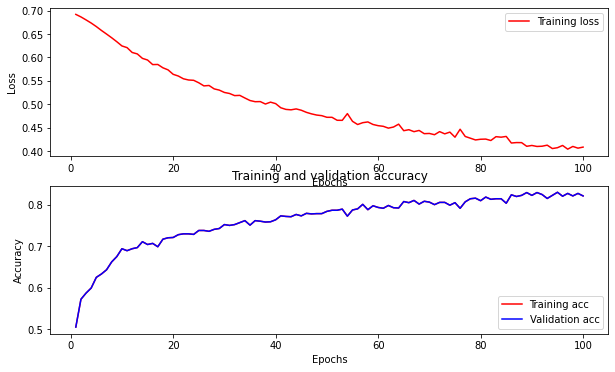

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**bold text**BERT ENCODINNG for predictions